In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from scipy import signal
%matplotlib inline

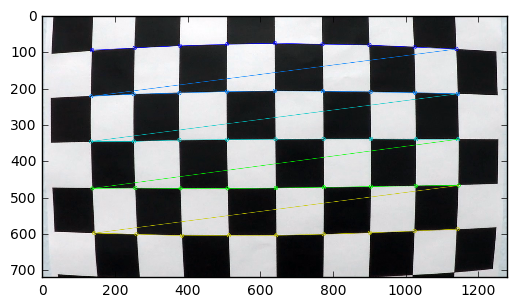

In [2]:
## EXAMPLE IMAGE WITH CORNERS DRAWN
nx = 9
ny = 5
img = cv2.imread("camera_cal/calibration1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret:
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

In [3]:
## LOOP THROUGH ALL IMAGES, GENERATE IMG AND OBJECT POINTS
images = glob.glob("camera_cal/calibration*.jpg")
objpoints = []
imgpoints = []
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

In [4]:
## GENERATE DISTORTION COEFFICIENTS
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                       img.shape[0:2], None,
                                                       None)

def cal_undistort(img, objpoints=objpoints, imgpoints=imgpoints):
    ## Undistort the picture
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [5]:
img = mpimg.imread("camera_cal/calibration1.jpg")
def cal_undistort(img, objpoints=objpoints, imgpoints=imgpoints):
    ## Undistort the picture
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
mpimg.imsave("output_images/undistorted_chessboard.jpg", cal_undistort(img))

In [6]:
img = mpimg.imread("test_images/test1.jpg")

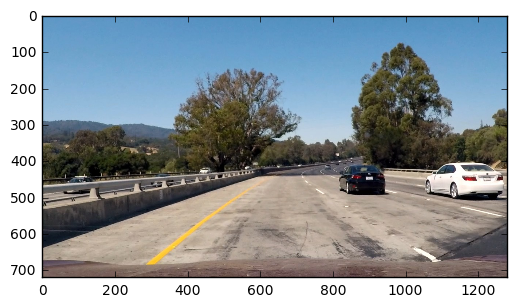

In [7]:
plt.imshow(img)

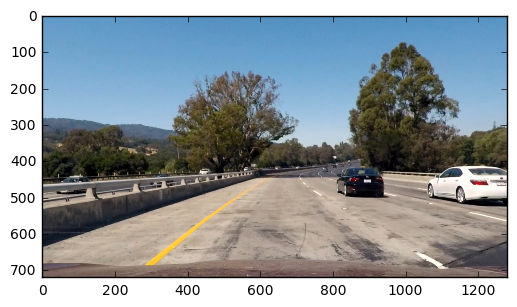

In [8]:
img = cal_undistort(img)
mpimg.imsave("output_images/transformed_road.jpg", img)
original = img #for final plotting
plt.imshow(img)

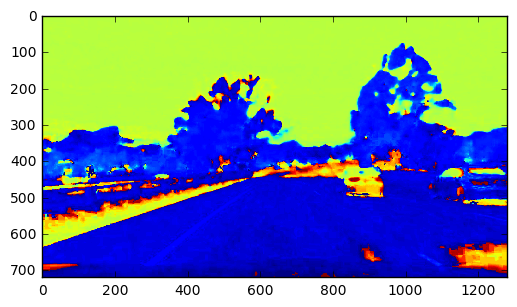

In [9]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
plt.imshow(h_channel)

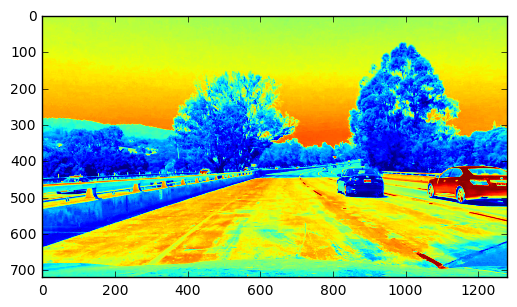

In [10]:
plt.imshow(l_channel)

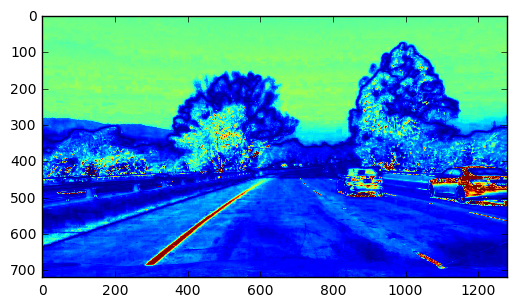

In [11]:
plt.imshow(s_channel)

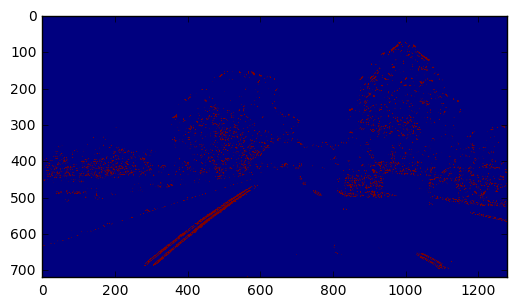

In [12]:
## APPLY THRESHOLDS TO DETECT LANELINES
def pipeline(img, sx_thresh=(25, 75), lx_thresh=(50, 75), dir_thresh=(
        0.2*3.14, 0.8*3.14), 
             ksize=9):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Calculate Sobel X in the S Channel
    sobelx_s = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the 
    abs_sobelx_s = np.absolute(sobelx_s) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_s = np.uint8(255*abs_sobelx_s/np.max(abs_sobelx_s))
    
    #Calculate direction of the gradient in the S Channel
    sobely_s = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=ksize))
    direction_s = np.arctan2(sobely_s, sobelx_s)
    
    
    l_channel = hls[:,:,1]
    # Calculate Sobel X in the L Channel
    sobelx_l = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the 
    abs_sobelx_l = np.absolute(sobelx_l) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel_l = np.uint8(255*abs_sobelx_l/np.max(abs_sobelx_l))
    
    #Calculate direction of the gradient in the L Channel
    sobely_l = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=ksize))
    direction_l = np.arctan2(sobely_l, sobelx_l)
    
    # Threshold. Sobel X and gradient direction must meet thresholds in either l or s channel
    sxbinary = np.zeros_like(scaled_sobel_l)
    sxbinary[((scaled_sobel_s >= sx_thresh[0]) & (scaled_sobel_s <= sx_thresh[1])
    & (direction_s >= dir_thresh[0]) & (direction_s <= dir_thresh[1])) |
            ((scaled_sobel_l >= lx_thresh[0]) & (scaled_sobel_l <= lx_thresh[1])
    & (direction_l >= dir_thresh[0]) & (direction_l <= dir_thresh[1]))] = 1
    return sxbinary

mpimg.imsave("output_images/binary.jpg", pipeline(img))
plt.imshow(pipeline(img))
detected = pipeline(img)

In [13]:
offset_x = 10
width = 300
height = 2270
#src = np.float32([[588, 446], [697, 448], [1079, 689], [233, 679]]) #Coordinates in pixel spaces
dst = np.float32([[offset_x, 0], [width-offset_x, 0], [width-offset_x, height], [offset_x, height]]) #Coordinates in real space (birdseye)

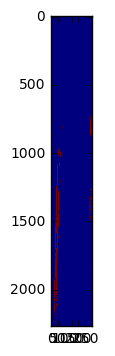

In [14]:
## WARP THE IMAGE INTO SIMULATED REAL-WORLD SPACE
def warp(img, dst=dst):
    src = np.float32([[img.shape[1]*.459, img.shape[0]*.619], [img.shape[1]*.544, img.shape[0]*.622], [img.shape[1]*.842, img.shape[0]*.957], [img.shape[1]*.182, img.shape[0]*.943]]) #Coordinates in pixel spaces
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (300, 2270),
                                 flags=cv2.INTER_LINEAR)
    return warped, src
plt.imshow(warp(detected)[0])
mpimg.imsave("output_images/distorted.jpg", warp(detected)[0])
warped, src = warp(detected)

In [18]:
def draw_lines(binary_warped, original,src=src):
    
    ##SLIDING WINDOW CODE- ALMOST THE SAME AS UDACITY VERSION
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    ##FITTING POLYNOMIALS
    
    #FITTING IMAGE POLYNOMIALS
    
    support = [len(lefty), len(leftx)]
    # The support variable gives the number of points in each lane. This is used to indicate the strength of the new fit.
    
    # Generate the new fit, and then smooth it with older fits.
    lane_one_fit = np.polyfit(lefty,leftx, 2)
    lane_one_fit = left.get_new_equations(lane_one_fit, support[0])

    lane_two_fit = np.polyfit(righty,rightx, 2)
    lane_two_fit = right.get_new_equations(lane_two_fit, support[1])
    
    

    sample_y = np.linspace(0, 2270, num=2271)
    
    lane_one_fitx = lane_one_fit[0]*sample_y**2 + lane_one_fit[1]*sample_y + \
        lane_one_fit[2]
    lane_two_fitx = lane_two_fit[0]*sample_y**2 + lane_two_fit[1]*sample_y + lane_two_fit[2]
    
    
    
    
    
    y_eval = np.max(sample_y)
    

    #FITTING REAL-WORLD POLYNOMIALS (for calculating the curvature and distance from center)
    
    ym_per_pix = 30/2260 # meters per pixel in y dimension
    xm_per_pix = 3.7/280 # meters per pixel in x dimension
    
    center_of_lane = lane_two_fitx[-1]-(lane_two_fitx[-1] - lane_one_fitx[-1])/2 # center of the lane lines in pixel space
    distance_from_center = (center_of_lane-binary_warped.shape[1]/2)*xm_per_pix #distance from center in real space
    
    

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_fit_cr = left_cr.get_new_equations(left_fit_cr, support[0])
    right_fit_cr = right_cr.get_new_equations(right_fit_cr, support[1])
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    
    ##DISTORT THE DETECTED LANE LINES BACK ONTO THE ORIGINAL IMAGE
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
#     plt.plot(leftx, lefty,"ro")
#     plt.plot(rightx, righty, "bo")
#     plt.plot(lane_one_fitx, sample_y, "g")
#     plt.plot(lane_two_fitx, sample_y, "y")
#     plt.show()
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([lane_one_fitx, sample_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lane_two_fitx, 
                                                            sample_y])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], 
                                                     original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    cv2.putText(result, "Radius Of Curvature: %.0f m"% ((left_curverad + right_curverad)/2), (25, 100), 
               cv2.FONT_HERSHEY_TRIPLEX, 2, (255, 255, 255))
    cv2.putText(result, "Distance From Center: %.2f m " % distance_from_center, (25, 200), 
               cv2.FONT_HERSHEY_TRIPLEX, 2, (255, 255, 255))
    return result

class PreviousData():
    ## This class helps to smooth out the fits from frame to frame
    a = 0
    b = 0
    c = 0
    support = 0 
    def attenuate(self):
        # weakens the influence of older frames
        self.support /= 1.5
    def get_new_equations(self, fit, new_support):
        # generates the new fit based on the support of both the new and old fits
        self.attenuate()
        squared_support = self.support**2
        squared_new_support = new_support**2
        denom = squared_support + squared_new_support
        self.a = (self.a * squared_support + fit[0] * squared_new_support)/denom
        self.b = (self.b * squared_support + fit[1] * squared_new_support)/denom
        self.c = (self.c * squared_support + fit[2] * squared_new_support)/denom
        self.support += new_support
        return self.a, self.b, self.c

# instances for the four polynomials
left = PreviousData()
right = PreviousData()
left_cr = PreviousData()
right_cr = PreviousData()

#plt.imshow(draw_lines(warped, original)) # need to comment out and rerun to reinstantiate the PreviousData objects at 0

In [19]:
#%load_ext line_profiler
def fully_process_image(img):
    img = cal_undistort(img)
    detected = pipeline(img)
    warped, src = warp(detected)
    drawn = draw_lines(warped, img, src)
    return drawn

video = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(fully_process_image)
white_clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



100%|██████████| 485/485 [03:35<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

